In [185]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from textblob import TextBlob
import advertools
import re
import spacy
import xgboost
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report,auc, 
                            roc_auc_score, precision_score,
                            recall_score,f1_score, accuracy_score)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
# import contextualSpellCheck
import nltk
import nltk.util
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to C:\Users\Ali
[nltk_data]     Haider\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ali
[nltk_data]     Haider\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
binary = "control_data.csv"
multi = "multi_class_data_balanced.csv"
final_data = pd.read_csv(binary)
final_data.rename(columns={"Disorder":"class"}, inplace=True)

In [188]:
pipeline_data = final_data.copy()

# Data Preprocessing

In [189]:
def clean_text(text:str) -> str:
    tokens = advertools.word_tokenize(text,phrase_len=1)
    emoji_token = advertools.extract_emoji(tokens[0])
    emoji_token = emoji_token["emoji_text"]
    for tok in range(0,len(emoji_token)):
        if emoji_token[tok]:
            tokens[0][tok] = " ".join(emoji_token[tok])
    clean_text = " ".join(tokens[0])
    clean_pattern = r"@\w+|#\w+|\W+|x+|https\.\//www\.(\w+|\W+)\.com|http\w*|www\.(\w+|\W+)\.com|user\w*|\d+"
    clean_text = re.sub(clean_pattern," ",clean_text).strip()
    clean_text = re.sub(r"\s+"," ",clean_text).strip()
    return clean_text

In [190]:
def text_lemmatize(text: str) -> str:
    lemma = WordNetLemmatizer()
    tokens = advertools.word_tokenize(text,phrase_len=1)
    text = [lemma.lemmatize(tok) for tok in tokens[0]]
    return " ".join(text)

In [191]:
def spell_check(text:str) -> str:
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe("contextual spellchecker")
    doc = nlp(text)
    return doc._.outcome_spellCheck

In [192]:
def remove_stopword(text: str) -> str:
    tokens = advertools.word_tokenize(text,phrase_len=1)[0]
    stop_words = stopwords.words("english")
    clean_word = [tok for tok in tokens if tok not in stop_words]
    return " ".join(clean_word)

# Vectorization

In [193]:
def generate_n_grams(text: str, n: list[int]) -> list[tuple]:
    tokens = advertools.word_tokenize(text,phrase_len=1)[0]
    if len(n)<=1:
        n_grams = list(nltk.ngrams(tokens,n[0],pad_right=True,right_pad_symbol="</s>"))
        bag_ngrams = " ".join(["_".join(c) for c in n_grams])
    else:
        bag_ngrams = " "
        for n_gram in range(n[0],n[1]+1):
            n_grams = list(nltk.ngrams(tokens,n_gram,pad_right=True,right_pad_symbol="</s>"))
            if n_gram==1:       
                n_grams = " ".join(["".join(c[0]) for c in n_grams])
                bag_ngrams+=n_grams
            else:
                n_grams = " ".join(["_".join(c) for c in n_grams])
                bag_ngrams+=" "+n_grams
    return bag_ngrams

In [194]:
def tfidf(train: pd.DataFrame, test:pd.DataFrame()):
    tf_idf = TfidfVectorizer()
    train_feat = tf_idf.fit_transform(train)
    test_feat = tf_idf.transform(test)
    return train_feat,test_feat

## Pipeline

In [195]:
def data_preprocess_pipeline(data_preprocess: pd.DataFrame,
                             ngram_range: list,
                            filename: str,
                            ) -> pd.DataFrame:
    data_preprocess = data_preprocess[~(data_preprocess["tweet"].isnull())]
    data_preprocess = data_preprocess[["class","tweet"]]
    data_preprocess.rename(columns={"class":"Disorder"}, inplace=True)
    data_preprocess["tweet"] = data_preprocess["tweet"].apply(clean_text)
    data_preprocess["tweet"] = data_preprocess["tweet"].apply(text_lemmatize)
    data_preprocess["tweet"] = data_preprocess["tweet"].apply(remove_stopword)
    data_preprocess = data_preprocess[data_preprocess["tweet"]!=""]
    data_preprocess["text_features"] = data_preprocess["tweet"].apply(lambda text: 
                                                                      generate_n_grams(text,n=ngram_range))
    print("saving preprocessed data")
    data_preprocess.to_csv(filename,index=False)
    print("data saved")
    return data_preprocess

# ML Models

In [196]:
def binary_classification_metrics(actuals: np.array, preds: np.array) -> pd.DataFrame:
    metrics_performance = pd.DataFrame()
    precision_0 = precision_score(actuals,preds, pos_label=0)
    precision_1 = precision_score(actuals,preds, pos_label=1)
    recall_0 = recall_score(actuals,preds,pos_label=0)
    recall_1 = recall_score(actuals,preds,pos_label=1)
    f1_0 = f1_score(actuals,preds,pos_label=0)
    f1_1 = f1_score(actuals,preds,pos_label=1)
    accuracy = accuracy_score(actuals,preds)
    metrics_performance["precision_0"] = [precision_0]
    metrics_performance["precision_1"] = [precision_1]
    metrics_performance["recall_0"] = [recall_0]
    metrics_performance["recall_1"] = [recall_1]
    metrics_performance["f1_0"] = [f1_0]
    metrics_performance["f1_1"] = [f1_1]
    metrics_performance["accuracy"] = [accuracy]
    return metrics_performance

In [197]:
def multi_classification_metrics(actuals: np.array, preds: np.array, average:"binary") -> pd.DataFrame:
    metrics_performance = pd.DataFrame()
    precision = precision_score(actuals,preds,average=average)
    recall = recall_score(actuals,preds,average=average)
    f1 = f1_score(actuals,preds,average=average)
    accuracy = accuracy_score(actuals,preds)
    metrics_performance["precision"] = [precision]
    metrics_performance["recall"] = [recall]
    metrics_performance["f1"] = [f1]
    metrics_performance["accuracy"] = [accuracy]
    return metrics_performance

# balanced Dataset training

In [2]:
ngram_range = [1,1]
data_preprocess = data_preprocess_pipeline(pipeline_data,
                                           ngram_range=ngram_range,
                                           filename="multi_class_balanced_data_preprocess.csv")

In [3]:
data_bin = data_preprocess[["text_features","Disorder"]]
diagnosed_group = data_bin[data_bin["Disorder"]!="CONTROL"]
diagnosed_group["Disorder"] = "DIAGNOSED"
control_group = data_bin[data_bin["Disorder"]=="CONTROL"]
data_bin = pd.concat([diagnosed_group,control_group],axis=0)
data_bin.reset_index(drop=True, inplace=True)
encode_target = {"DIAGNOSED":1,
                "CONTROL":0}
data_bin["Disorder"] = data_bin["Disorder"].map(encode_target)
data_bin.head()

In [4]:
data_bin = data_preprocess[["text_features","Disorder"]]
data_bin = data_bin[data_bin["Disorder"]!="CONTROL"]
encode_target = dict(zip(data_bin["Disorder"].unique(),np.arange(0,data_bin["Disorder"].nunique(),dtype=int)))
data_bin["Disorder"] = data_bin["Disorder"].map(encode_target)
data_bin["Disorder"]=data_bin["Disorder"].map(int)
data_bin.head()

In [237]:
data_bin['Disorder'].value_counts()

Disorder
1    3018
0    2959
3    2888
6    2719
2    2458
4    2143
8    1402
7     402
5     243
Name: count, dtype: int64

In [238]:
X = data_bin[["text_features"]]
y = data_bin[["Disorder"]]

In [239]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                             stratify=y,random_state=42)
metrics_performance = pd.DataFrame()
train_data,test_data = tfidf(X_train["text_features"],X_test["text_features"])

In [240]:
log_reg = LogisticRegression(n_jobs=-1)
log_reg.fit(train_data,y_train)

LogisticRegression(n_jobs=-1)

In [241]:
y_pred = log_reg.predict(test_data)
y_pred

array([1, 0, 6, ..., 6, 1, 0], dtype=int64)

In [243]:
binary_classification_metrics(y_test.values,y_pred)

In [244]:
multi_perf = multi_classification_metrics(y_test.values,y_pred,"macro")
multi_perf

,precision,recall,f1,accuracy
0,0.651007,0.54415,0.56197,0.654785


In [278]:
from sklearn.metrics import (RocCurveDisplay, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay, confusion_matrix,
                            multilabel_confusion_matrix)

In [222]:
fpr,tpr,threshold = roc_curve(y_test.values,y_pred)
auc_score = auc(fpr,tpr)
display_roc_auc = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_score)

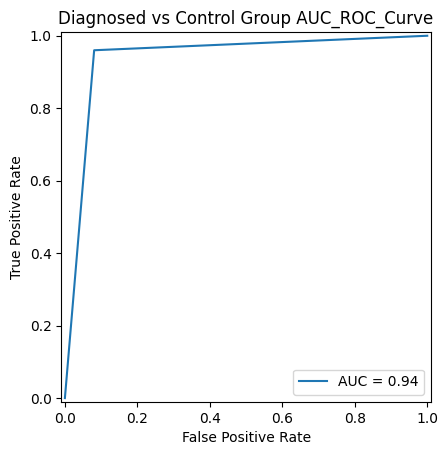

In [224]:
display_roc_auc.plot()
plt.title("Diagnosed vs Control Group AUC_ROC_Curve")
plt.show()

In [246]:
get_disorders = {v:k for k,v in encode_target.items()}
get_disorders

{0: 'SCHIZOPHRENIA',
 1: 'ADHD',
 2: 'PTSD',
 3: 'OCD',
 4: 'DEPRESSION',
 5: 'BIPOLAR',
 6: 'ANXIETY',
 7: 'EATING DISORDER',
 8: 'AUTISM'}

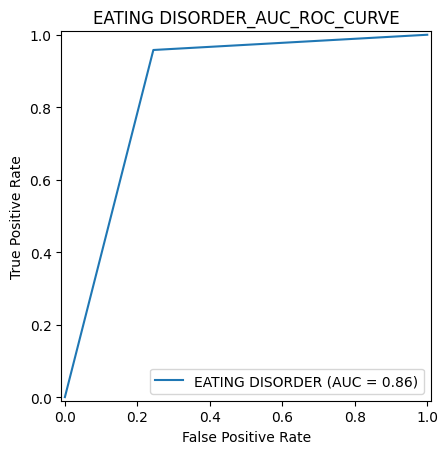

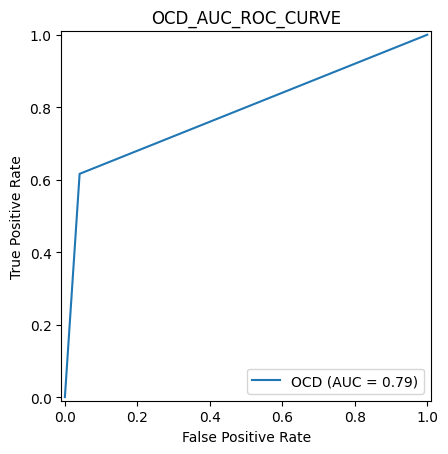

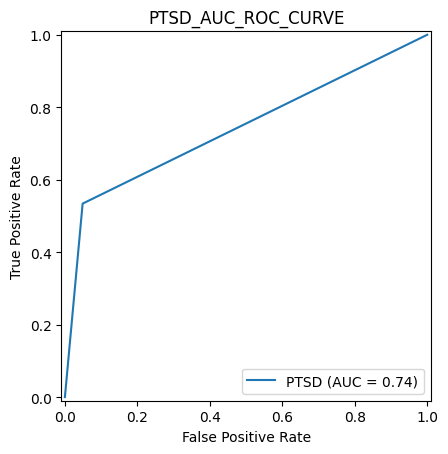

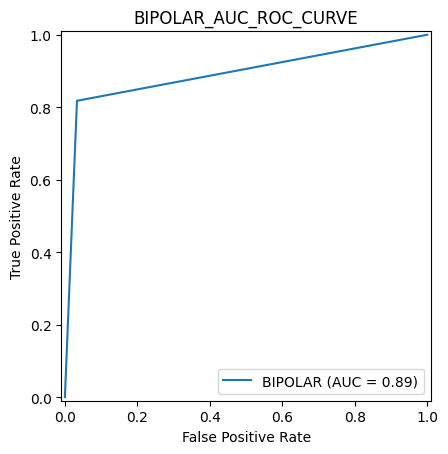

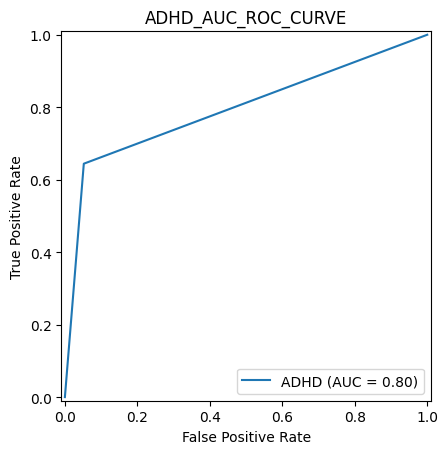

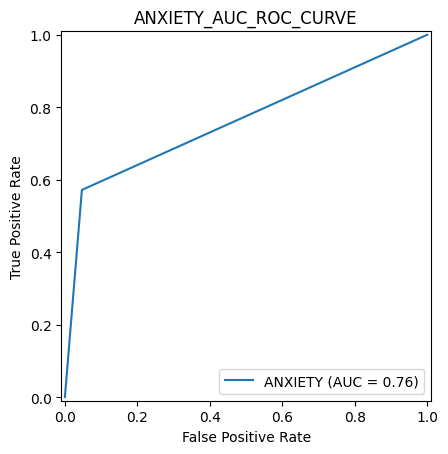

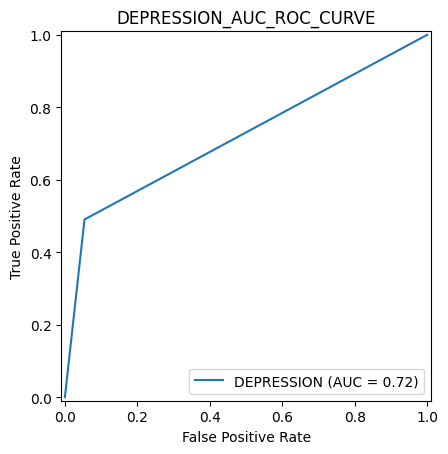

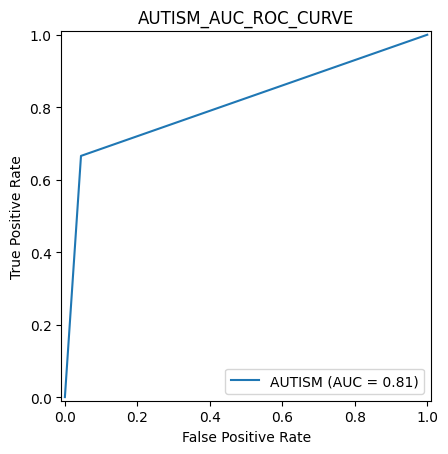

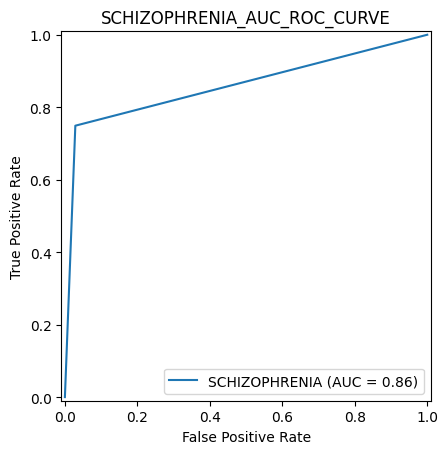

In [184]:
for labels in np.unique(y_pred):
    if labels == 0:
        cls_pred = np.where(y_pred==labels,y_pred,1)
        cls_act  = np.where(y_test==labels,y_test,1)
    elif labels == 1:
        cls_pred = np.where(y_pred==labels,y_pred,0)
        cls_act  = np.where(y_test==labels,y_test,0)
    else:
        cls_pred = np.where(y_pred==labels,1,0)
        cls_act  = np.where(y_test==labels,1,0)
    fpr,tpr,threshold = roc_curve(cls_act,cls_pred)
    auc_score = auc(fpr,tpr)
    display_roc_auc = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_score, estimator_name=f'{get_disorders[labels]}')
    display_roc_auc.plot()
    plt.title(f'{get_disorders[labels]}_AUC_ROC_CURVE')

In [229]:
y_pred_label = np.where(y_pred==0,'CONTROL','DIAGNOSED')
y_actual_label = np.where(y_test==0,'CONTROL','DIAGNOSED')

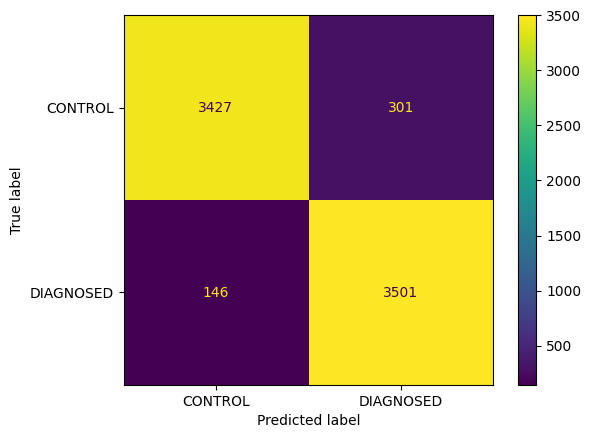

In [233]:
ConfusionMatrixDisplay.from_predictions(y_actual_label,y_pred_label,labels = ['CONTROL','DIAGNOSED'])

In [264]:
multi_preds_df = pd.DataFrame({'preds':y_pred})
multi_preds_df['act'] = y_test.Disorder.values
multi_preds_df['preds'] = multi_preds_df['preds'].map(get_disorders)
multi_preds_df['act'] = multi_preds_df['act'].map(get_disorders)

In [265]:
multi_preds_df

,preds,act
0,ADHD,ADHD
1,SCHIZOPHRENIA,SCHIZOPHRENIA
2,ANXIETY,ANXIETY
3,ADHD,ADHD
4,ADHD,AUTISM
...,...,...
3642,DEPRESSION,DEPRESSION
3643,SCHIZOPHRENIA,OCD
3644,ANXIETY,ANXIETY
3645,ADHD,ADHD


In [279]:
cnf = confusion_matrix(multi_preds_df.act.values,multi_preds_df.preds.values)
cnf

array([[444,  22,   7,   0,  27,   1,  62,  23,  18],
       [ 41, 385,  10,   2,  16,   0,  40,  30,  20],
       [ 63,  36,  86,   2,  25,   1,  30,  20,  17],
       [  3,  15,   0,  15,   6,   0,   2,   5,   2],
       [ 42,  31,  16,   2, 244,   0,  48,  33,  13],
       [ 15,  13,   2,   0,  10,   9,   5,  16,  10],
       [ 69,  22,  15,   0,  17,   1, 429,  15,  10],
       [ 57,  33,   7,   3,  31,   1,  41, 293,  26],
       [ 31,  24,   4,   0,  15,   0,  17,  18, 483]], dtype=int64)

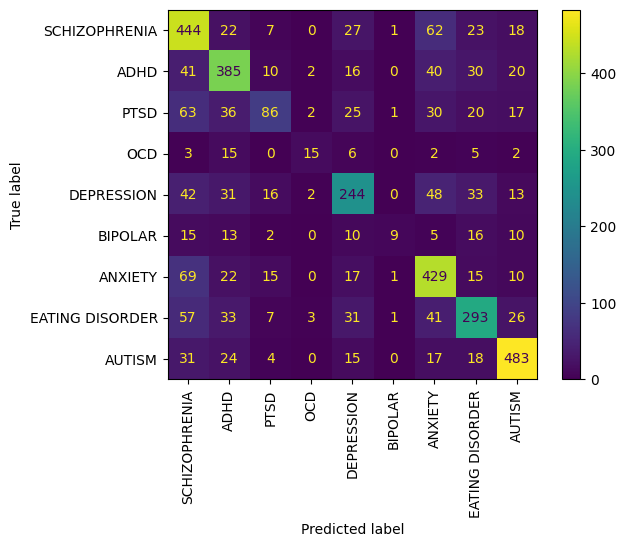

In [283]:
ConfusionMatrixDisplay(confusion_matrix=cnf, display_labels=list(get_disorders.values())).plot()
plt.xticks(rotation=90)
plt.show()